In [1]:
import string
from datetime import datetime
from pathlib import Path
from uuid import UUID

import numpy as np
import xarray as xr

In [2]:
DATETIME_START = datetime(2009, 1, 1)
DATETIME_STOP = datetime(2017, 1, 1)

In [3]:
DATAROOT = Path("../data/runoff")
datanames = ["era5l", "era5lnmp", "glofas", "grfr", "cnrd", "cldasnmp"]

REPROCESS_YRMEAN = False
YRMEAN_FILE = Path("runoff_yrmean.nc")

REPROCESS_SEAMEAN = False
SEAMEAN_FILE = Path("runoff_seamean.nc")


In [4]:
import matplotlib.pyplot as plt

# plotting settings
FIGROOT = Path("../fig")
FIGDPI = 600
FIGSUFFIX = ".pdf"

plt.style.use("seaborn-v0_8-colorblind")
plt.rcParams.update(
    {
        "savefig.pad_inches": 0.05 / 2.54,
        "grid.linewidth": 0.25,
        "axes.titlesize": 8,
        "axes.titlepad": 0.05,
        "axes.labelsize": 8,
        "xtick.labelsize": 8,
        "ytick.labelsize": 8,
        "legend.fontsize": 8,
        "text.usetex": True,
    }
)

In [5]:
if REPROCESS_YRMEAN or not YRMEAN_FILE.exists():
    yrmeandata: dict[str, xr.DataArray] = {}

    for dsn in datanames:
        print(f"Processing {dsn}")
        data = xr.open_dataset(DATAROOT / f"{dsn}.nc")
        data = data["mrro"].sel(time=slice(DATETIME_START, DATETIME_STOP))
        yrmeandata[dsn] = data.mean(dim="time")
        data.close()
    runoff_yrmean = xr.Dataset(
        data_vars={dsn: (["lat", "lon"], yrmeandata[dsn].data) for dsn in datanames},
        coords={
            "lat": list(yrmeandata.values())[0]["lat"].data,
            "lon": list(yrmeandata.values())[0]["lon"].data,
        },
    )

    runoff_yrmean.to_netcdf(YRMEAN_FILE)
else:
    runoff_yrmean = xr.open_dataset(YRMEAN_FILE)

In [6]:
station: dict[UUID, tuple[float, float]] = {}
with open("../data/station.csv", "rt") as f:
    next(f)
    for line in f:
        sid, _name, _merit, _rid, lat_, lon_ = line.strip().split(",")
        station[UUID(sid)] = (float(lat_), float(lon_))

station_pinyin = {
    UUID("urn:uuid:E4FF26A2-3871-481A-9A83-D43847596BB0"): "ZMD",
    UUID("urn:uuid:AC5B1300-C6EE-4395-A285-D77C6B3A1C95"): "BT",
    UUID("urn:uuid:2947AFEF-51B6-4B02-82F7-995D12185682"): "GT",
    UUID("urn:uuid:50CC5DFB-734F-4E67-A8F5-4095D0D72E85"): "BZL",
}

selected_stations = [
    UUID("urn:uuid:E4FF26A2-3871-481A-9A83-D43847596BB0"),
    UUID("urn:uuid:2947AFEF-51B6-4B02-82F7-995D12185682"),
    UUID("urn:uuid:50CC5DFB-734F-4E67-A8F5-4095D0D72E85"),
]

labels = {
    "era5l": "ERA5-Land",
    "glofas": "GloFAS",
    "glofas-mc": "GloFAS-MC",
    "grfr": "GRFR",
    "grfr-mc": "GRFR-MC",
    "cnrd": "CNRD",
    "era5lnmp": "ERA5-Land/NoahMP",
    "cldasnmp": "CLDAS/NoahMP",
}

# Multiyear averaged runoff

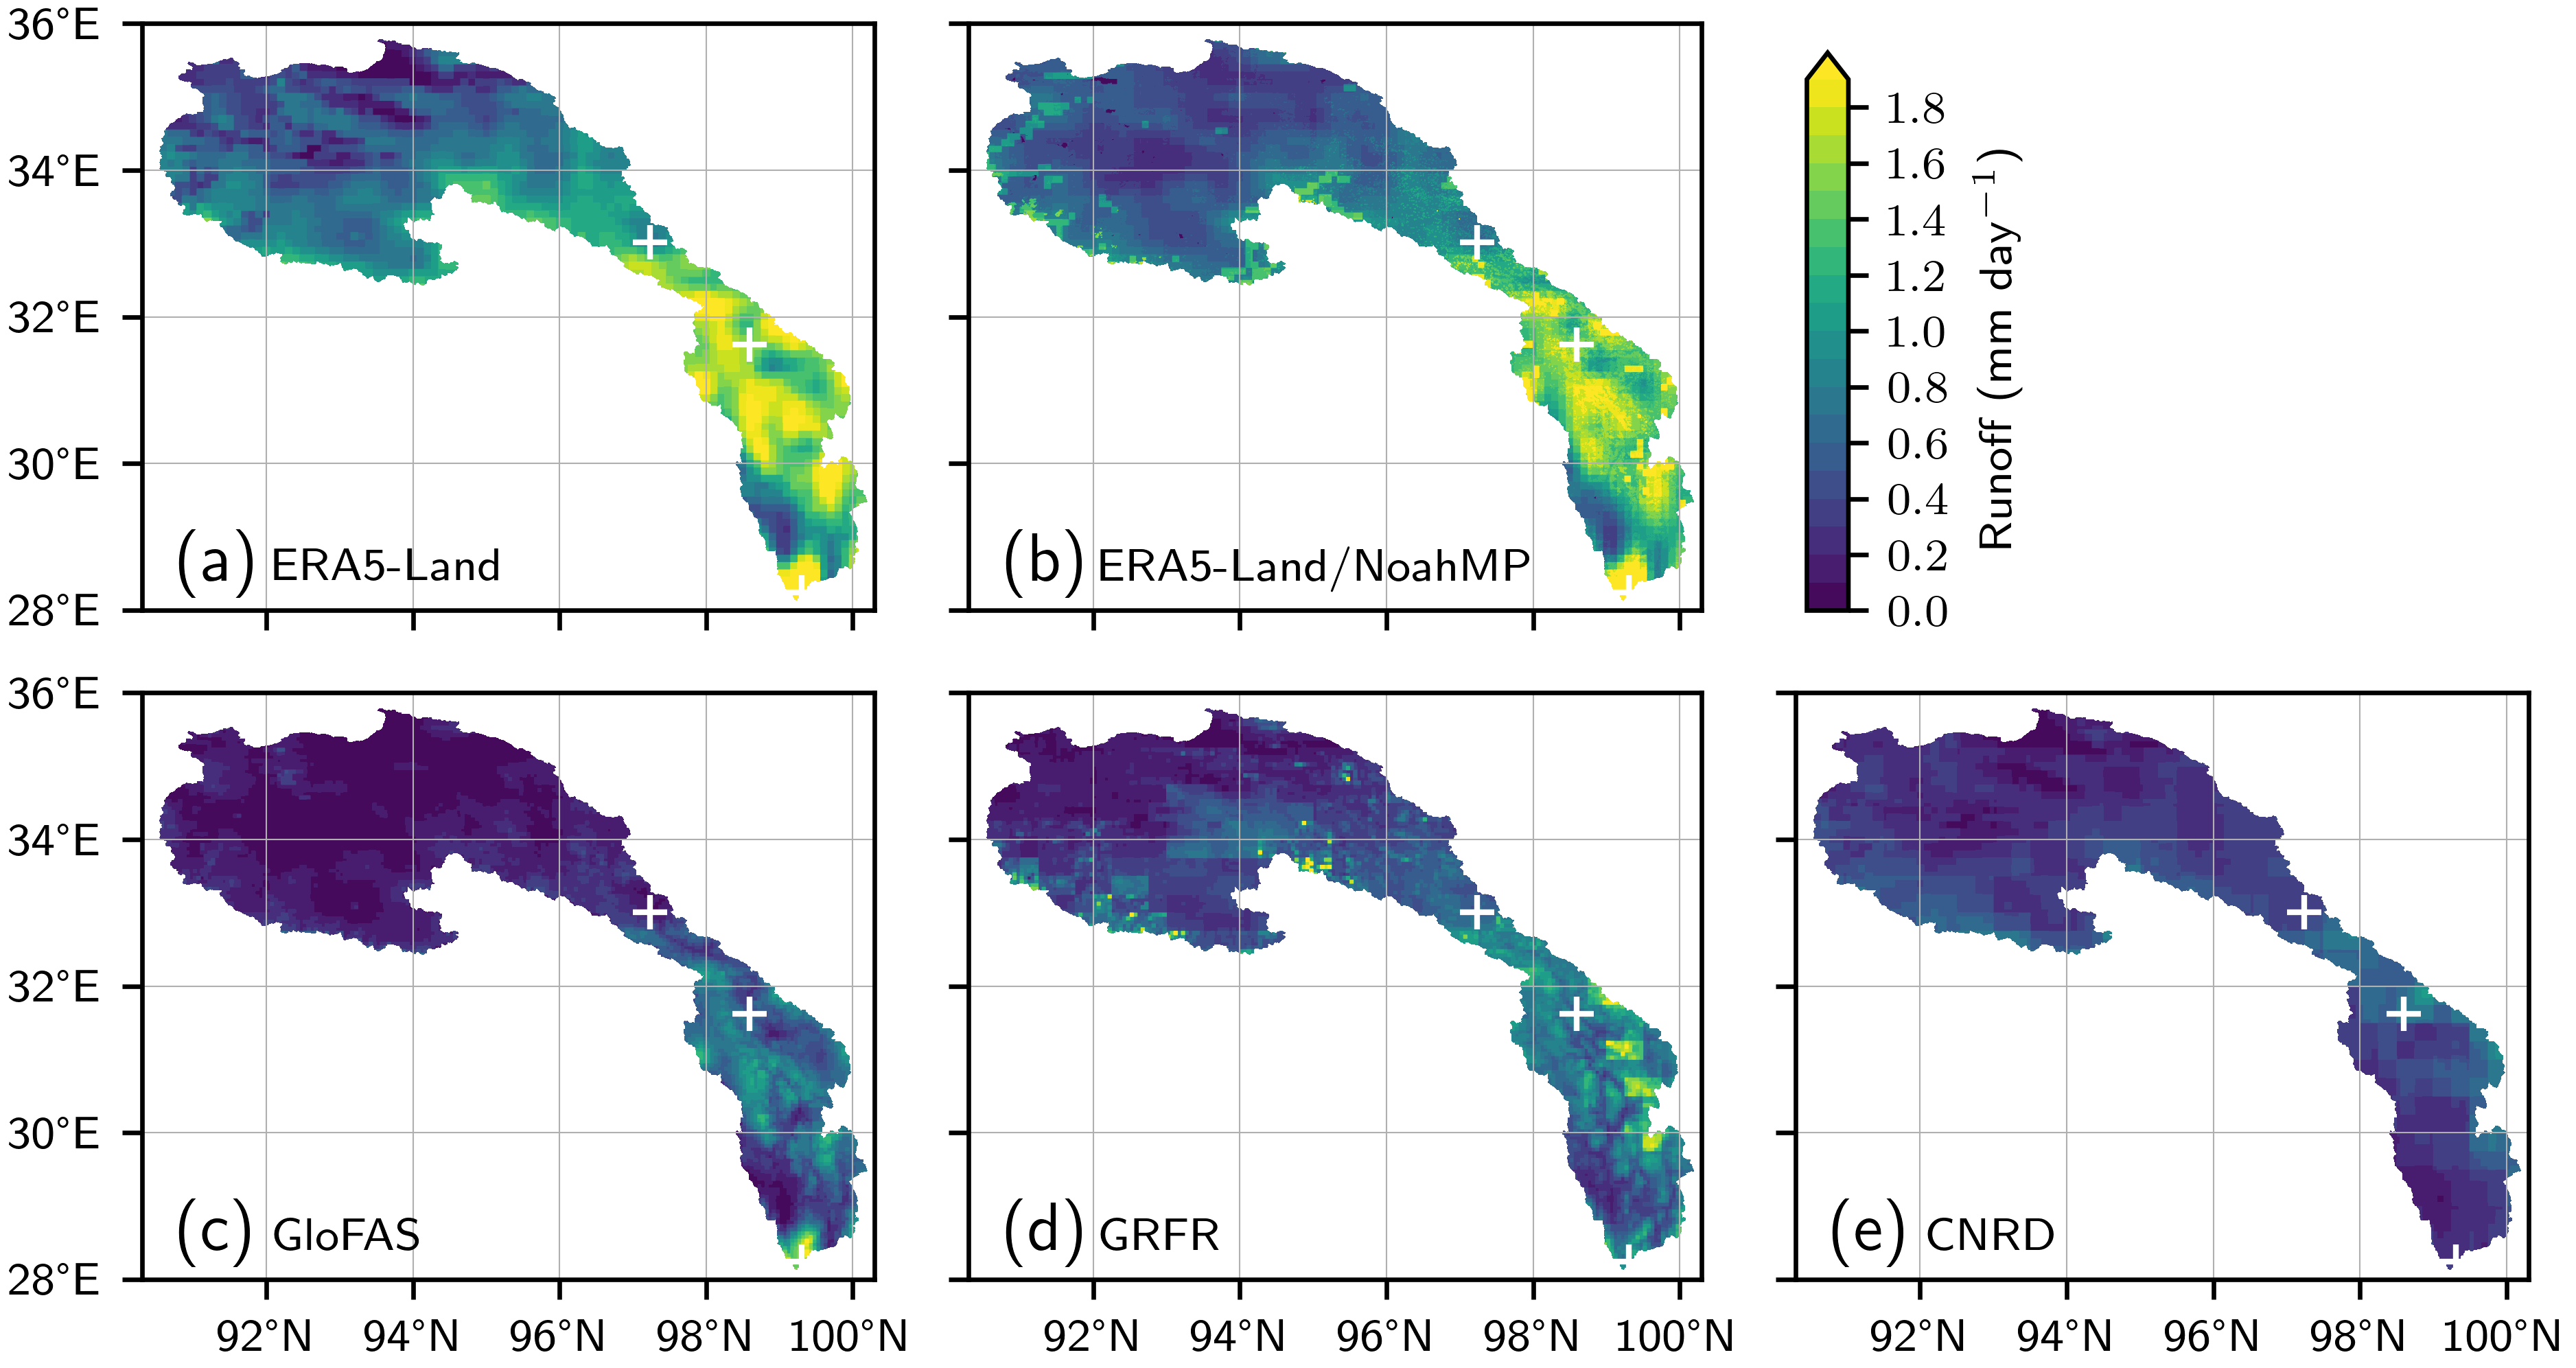

In [7]:
fig = plt.figure(figsize=(16 / 2.54, 8.6 / 2.54), dpi=FIGDPI, layout="constrained")
axs = fig.subplots(2, 3, sharex=True, sharey=True, squeeze=False)

levels = np.arange(0, 2.0, 0.1)

axs_map = {
    "era5l": axs[0, 0],
    "era5lnmp": axs[0, 1],
    "glofas": axs[1, 0],
    "grfr": axs[1, 1],
    "cnrd": axs[1, 2],
}

for i, dsn in enumerate(axs_map.keys()):
    ax = axs_map[dsn]
    cf = ax.contourf(
        runoff_yrmean["lon"],
        runoff_yrmean["lat"],
        (runoff_yrmean[dsn]) * (3600 * 24),
        levels=levels,
        extend="max",
    )
    ax.text(
        0.05,
        0.05,
        f"({string.ascii_lowercase[i]})",
        transform=ax.transAxes,
        ha="left",
        va="baseline",
        fontsize=12,
    )
    ax.text(
        0.18,
        0.05,
        f"{labels[dsn]}",
        transform=ax.transAxes,
        ha="left",
        va="baseline",
        fontsize=8,
    )
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_aspect("equal")
    ax.grid(True)

    for sid in selected_stations:
        lat_, lon_ = station[sid]
        ax.plot(lon_, lat_, "+", color="white", markersize=6)

axs[0, 0].set_yticks([28, 30, 32, 34, 36])
axs[0, 0].set_yticklabels(["28°E", "30°E", "32°E", "34°E", "36°E"])
axs[0, 0].set_ylim([28.0, 36])
axs[0, 0].set_xticks([92, 94, 96, 98, 100])
axs[0, 0].set_xticklabels(["92°N", "94°N", "96°N", "98°N", "100°N"])
axs[0, 0].set_xlim([90.3, 100.3])

axs[0, 2].set_visible(False)

cb = fig.colorbar(
    cf,
    cax=plt.axes((0.7, 0.55, 0.016, 0.4)),
    orientation="vertical",
    # pad=0.05,
    # aspect=50,
    # shrink=0.6,
)
cb.set_label("Runoff (mm day$^{-1}$)")

fig.savefig(FIGROOT.joinpath("runoff_mean").with_suffix(FIGSUFFIX), bbox_inches="tight")

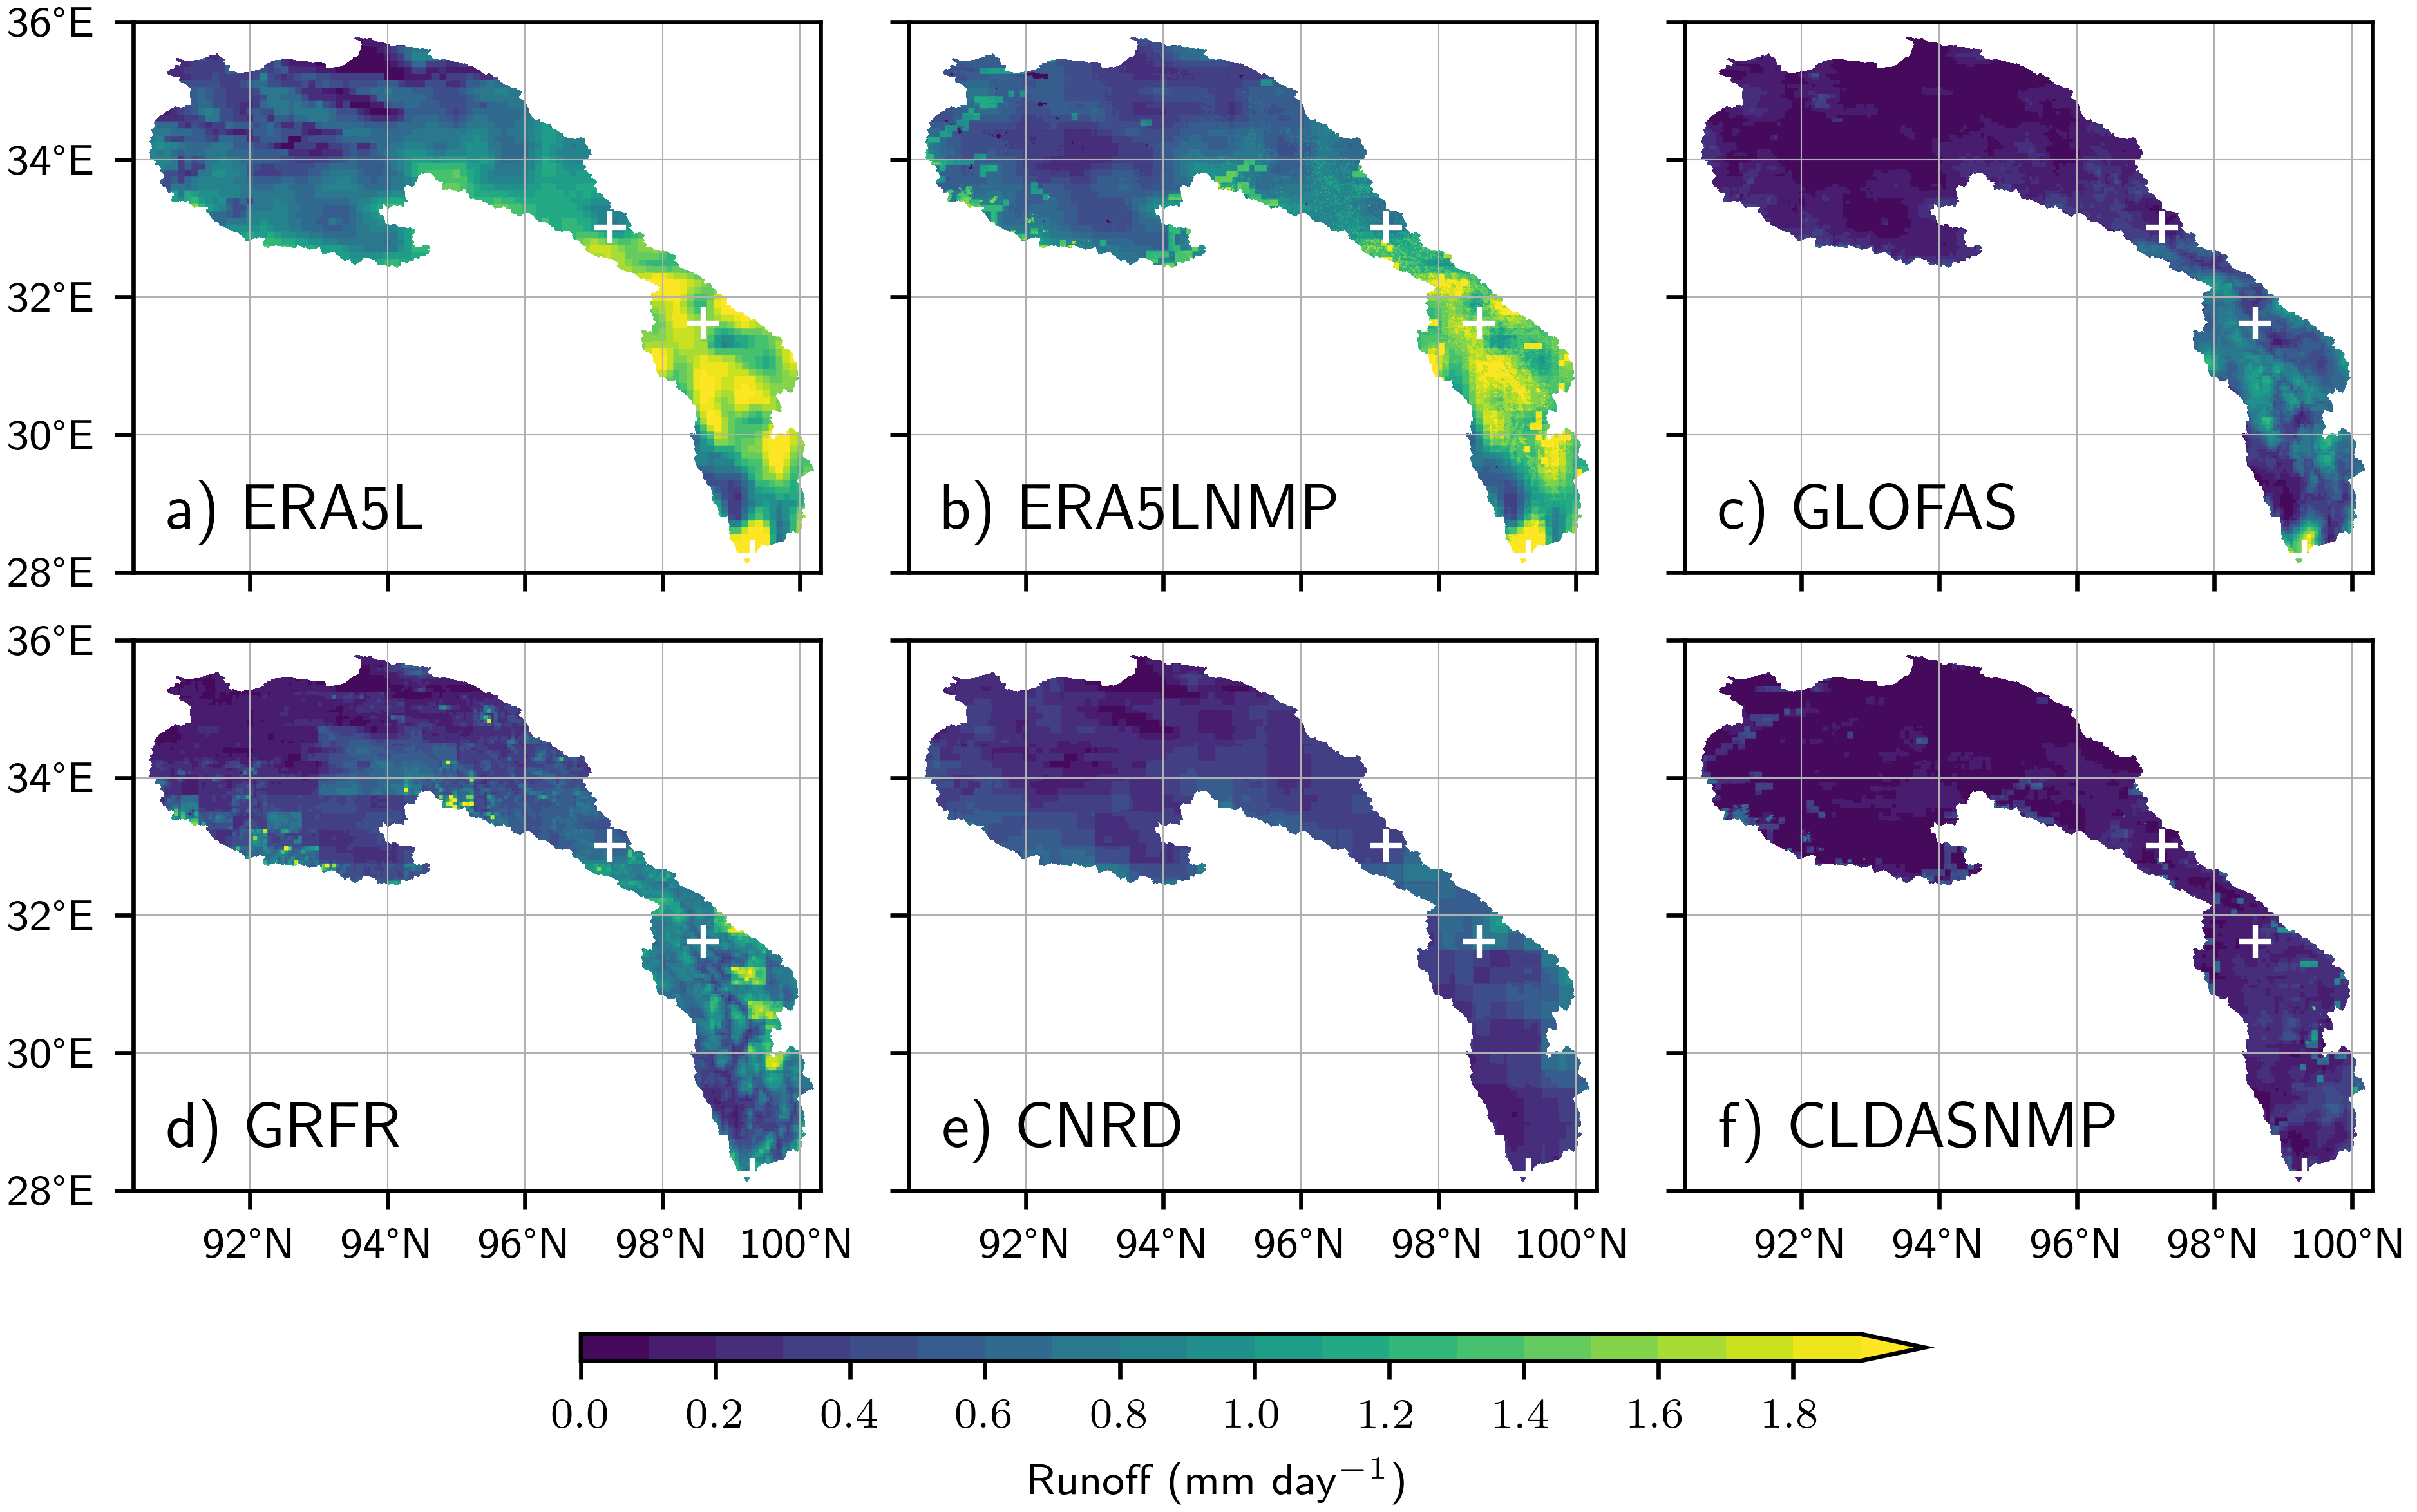

In [8]:
fig = plt.figure(figsize=(16 / 2.54, 10 / 2.54), dpi=FIGDPI, layout="constrained")
axs = fig.subplots(2, 3, sharex=True, sharey=True, squeeze=False)

levels = np.arange(0, 2.0, 0.1)

for i, dsn in enumerate(datanames):
    ax = axs.flat[i]
    cf = ax.contourf(
        runoff_yrmean["lon"],
        runoff_yrmean["lat"],
        (runoff_yrmean[dsn]) * (3600 * 24),
        levels=levels,
        extend="max",
    )
    ax.text(
        0.05,
        0.05,
        f"{string.ascii_lowercase[i]}) {dsn.upper()}",
        transform=ax.transAxes,
        ha="left",
        va="bottom",
        fontsize=12,
    )
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_aspect("equal")
    ax.grid(True)

    for sid in selected_stations:
        lat_, lon_ = station[sid]
        ax.plot(lon_, lat_, "+", color="white", markersize=6)

axs[0, 0].set_yticks([28, 30, 32, 34, 36])
axs[0, 0].set_yticklabels(["28°E", "30°E", "32°E", "34°E", "36°E"])
axs[0, 0].set_ylim([28.0, 36])
axs[0, 0].set_xticks([92, 94, 96, 98, 100])
axs[0, 0].set_xticklabels(["92°N", "94°N", "96°N", "98°N", "100°N"])
axs[0, 0].set_xlim([90.3, 100.3])

cb = fig.colorbar(cf, ax=axs, orientation="horizontal", pad=0.05, aspect=50, shrink=0.6)
cb.set_label("Runoff (mm day$^{-1}$)")

fig.savefig(
    FIGROOT.joinpath("runoff_mean_all").with_suffix(FIGSUFFIX), bbox_inches="tight"
)

# Seasonal Mean

In [9]:
if REPROCESS_SEAMEAN or not SEAMEAN_FILE.exists():
    seameandata: dict[str, dict[str, xr.DataArray]] = {}
    for dsn in datanames:
        print(f"Processing {dsn}")
        data = xr.open_dataset(DATAROOT / f"{dsn}.nc")
        data = data["mrro"].sel(time=slice(DATETIME_START, DATETIME_STOP))
        seameandata[dsn] = data.groupby("time.season").mean("time")
        data.close()

    runoff_seamean = xr.Dataset(
        data_vars={
            dsn: (["season", "lat", "lon"], seameandata[dsn].data) for dsn in datanames
        },
        coords={
            "lat": list(seameandata.values())[0]["lat"].data,
            "lon": list(seameandata.values())[0]["lon"].data,
            "season": [str(x) for x in list(seameandata.values())[0]["season"].data],
        },
    )

    runoff_seamean.to_netcdf(SEAMEAN_FILE)
else:
    runoff_seamean = xr.open_dataset(SEAMEAN_FILE)

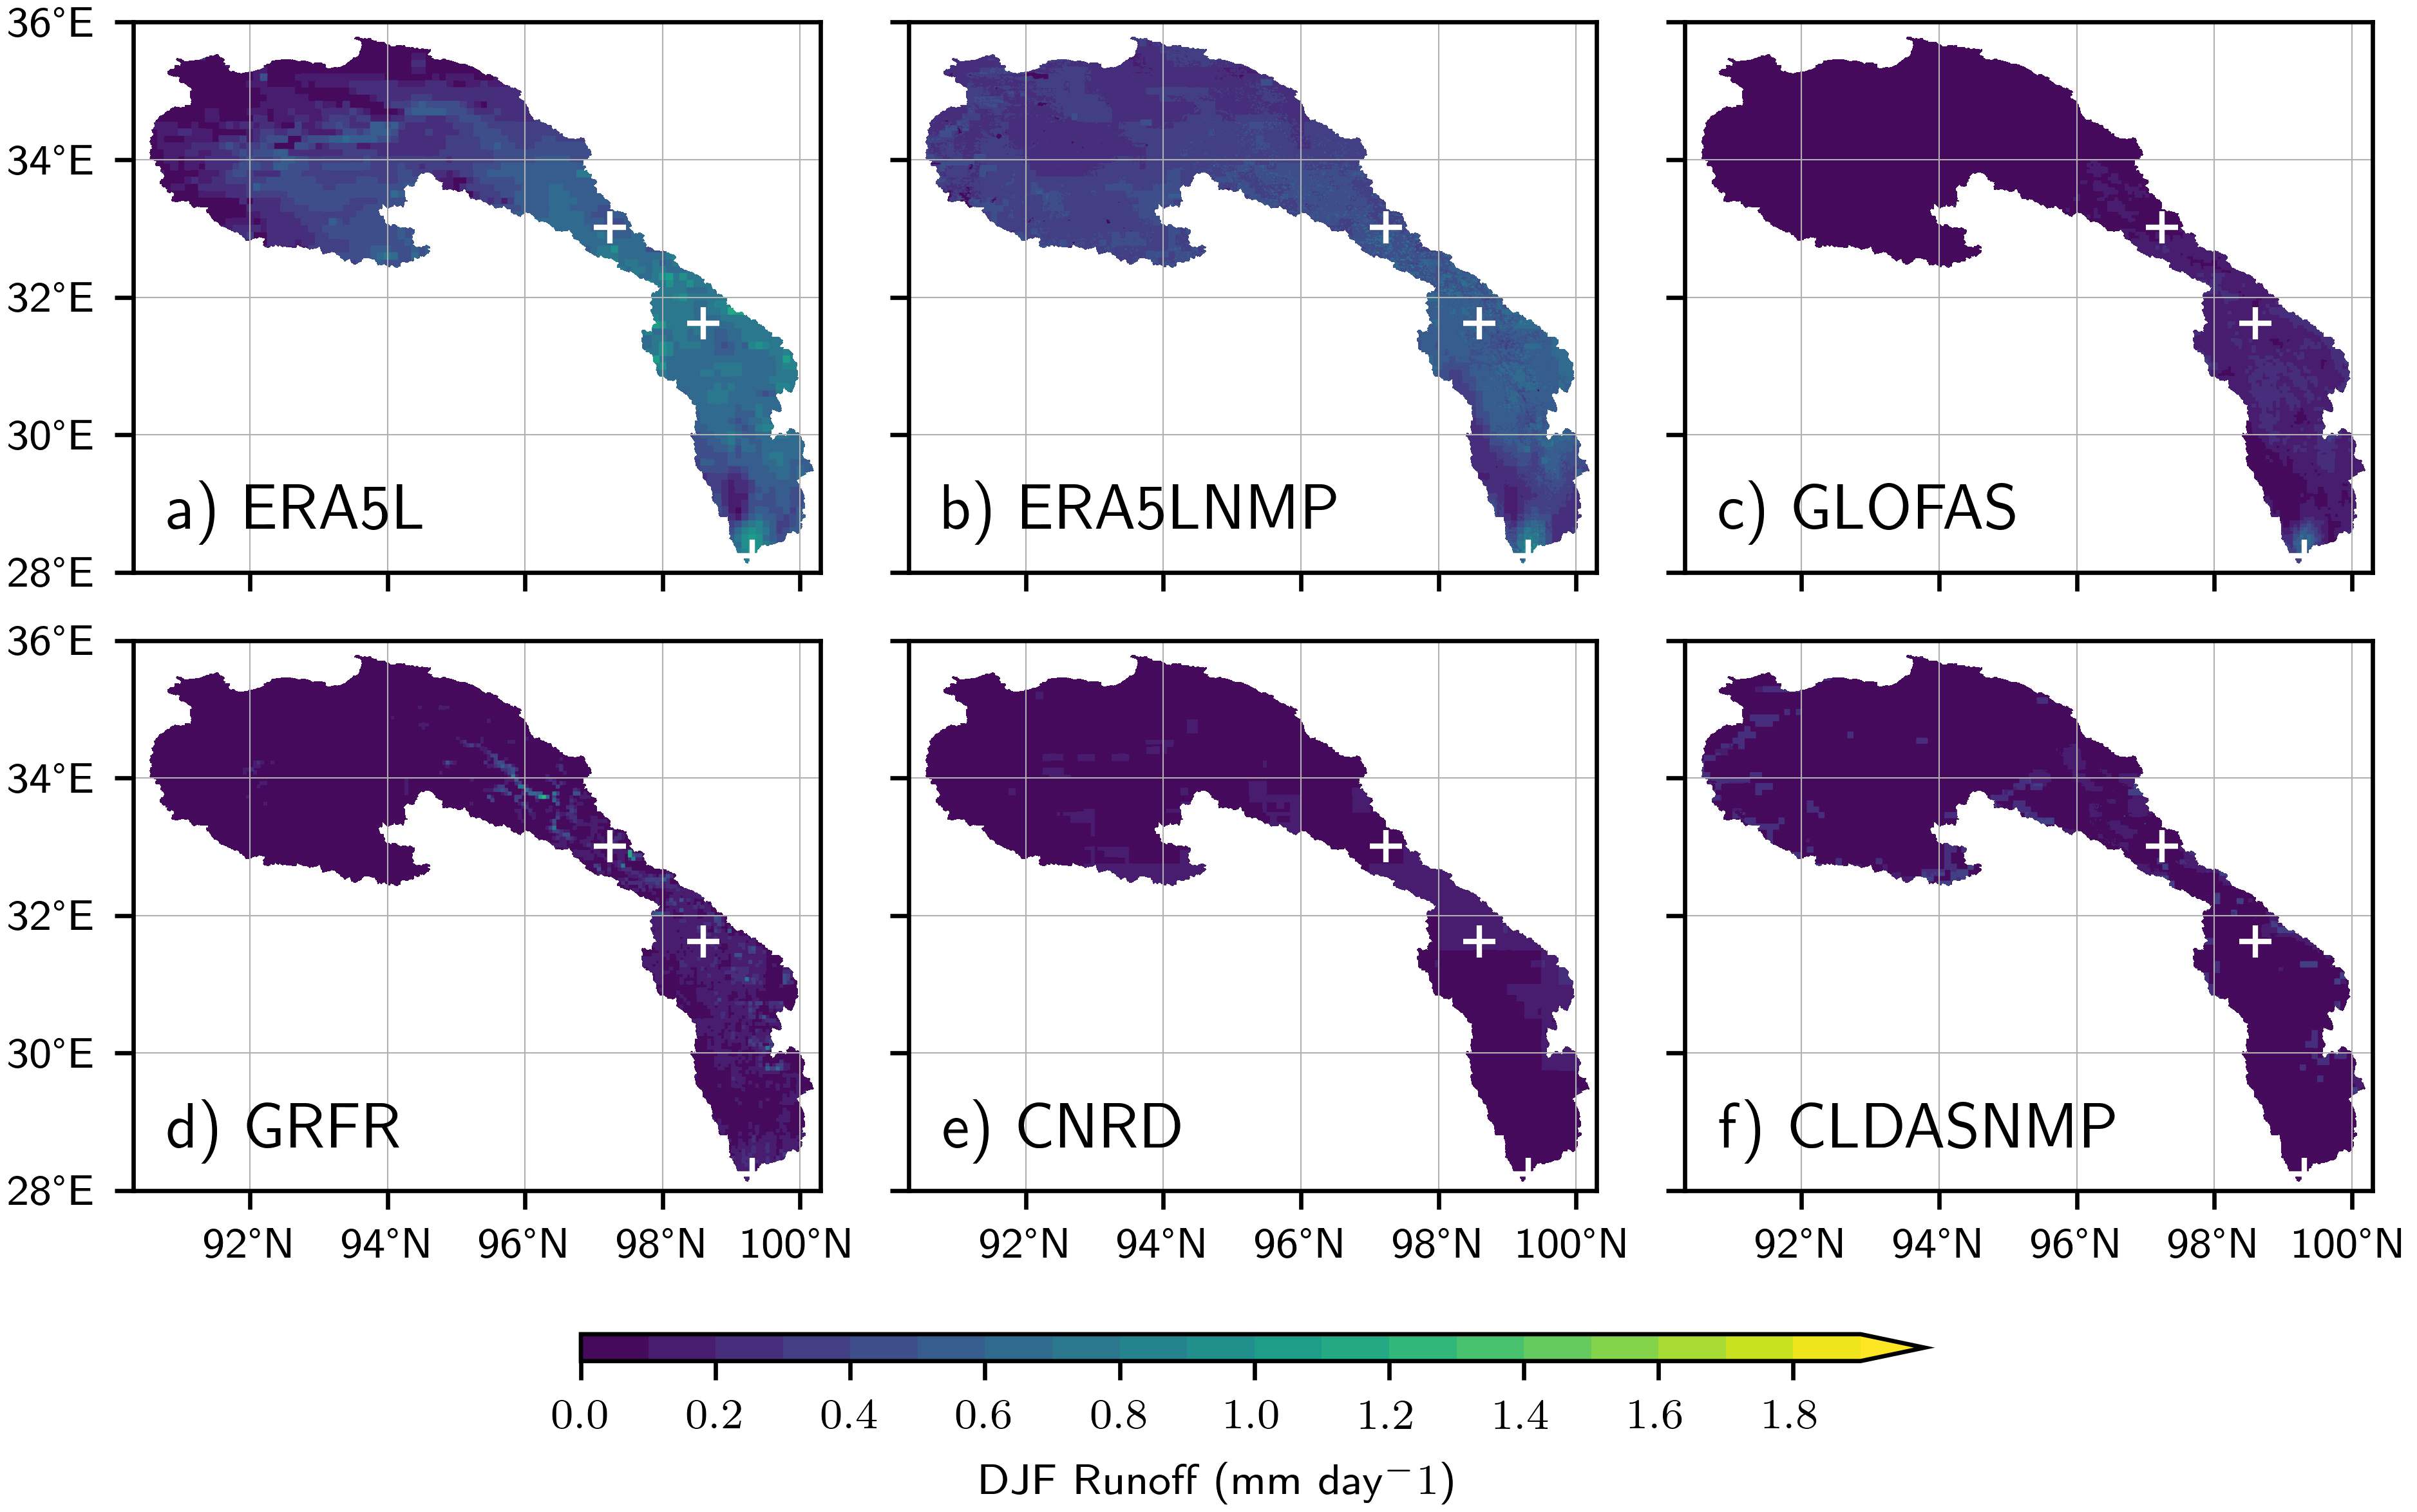

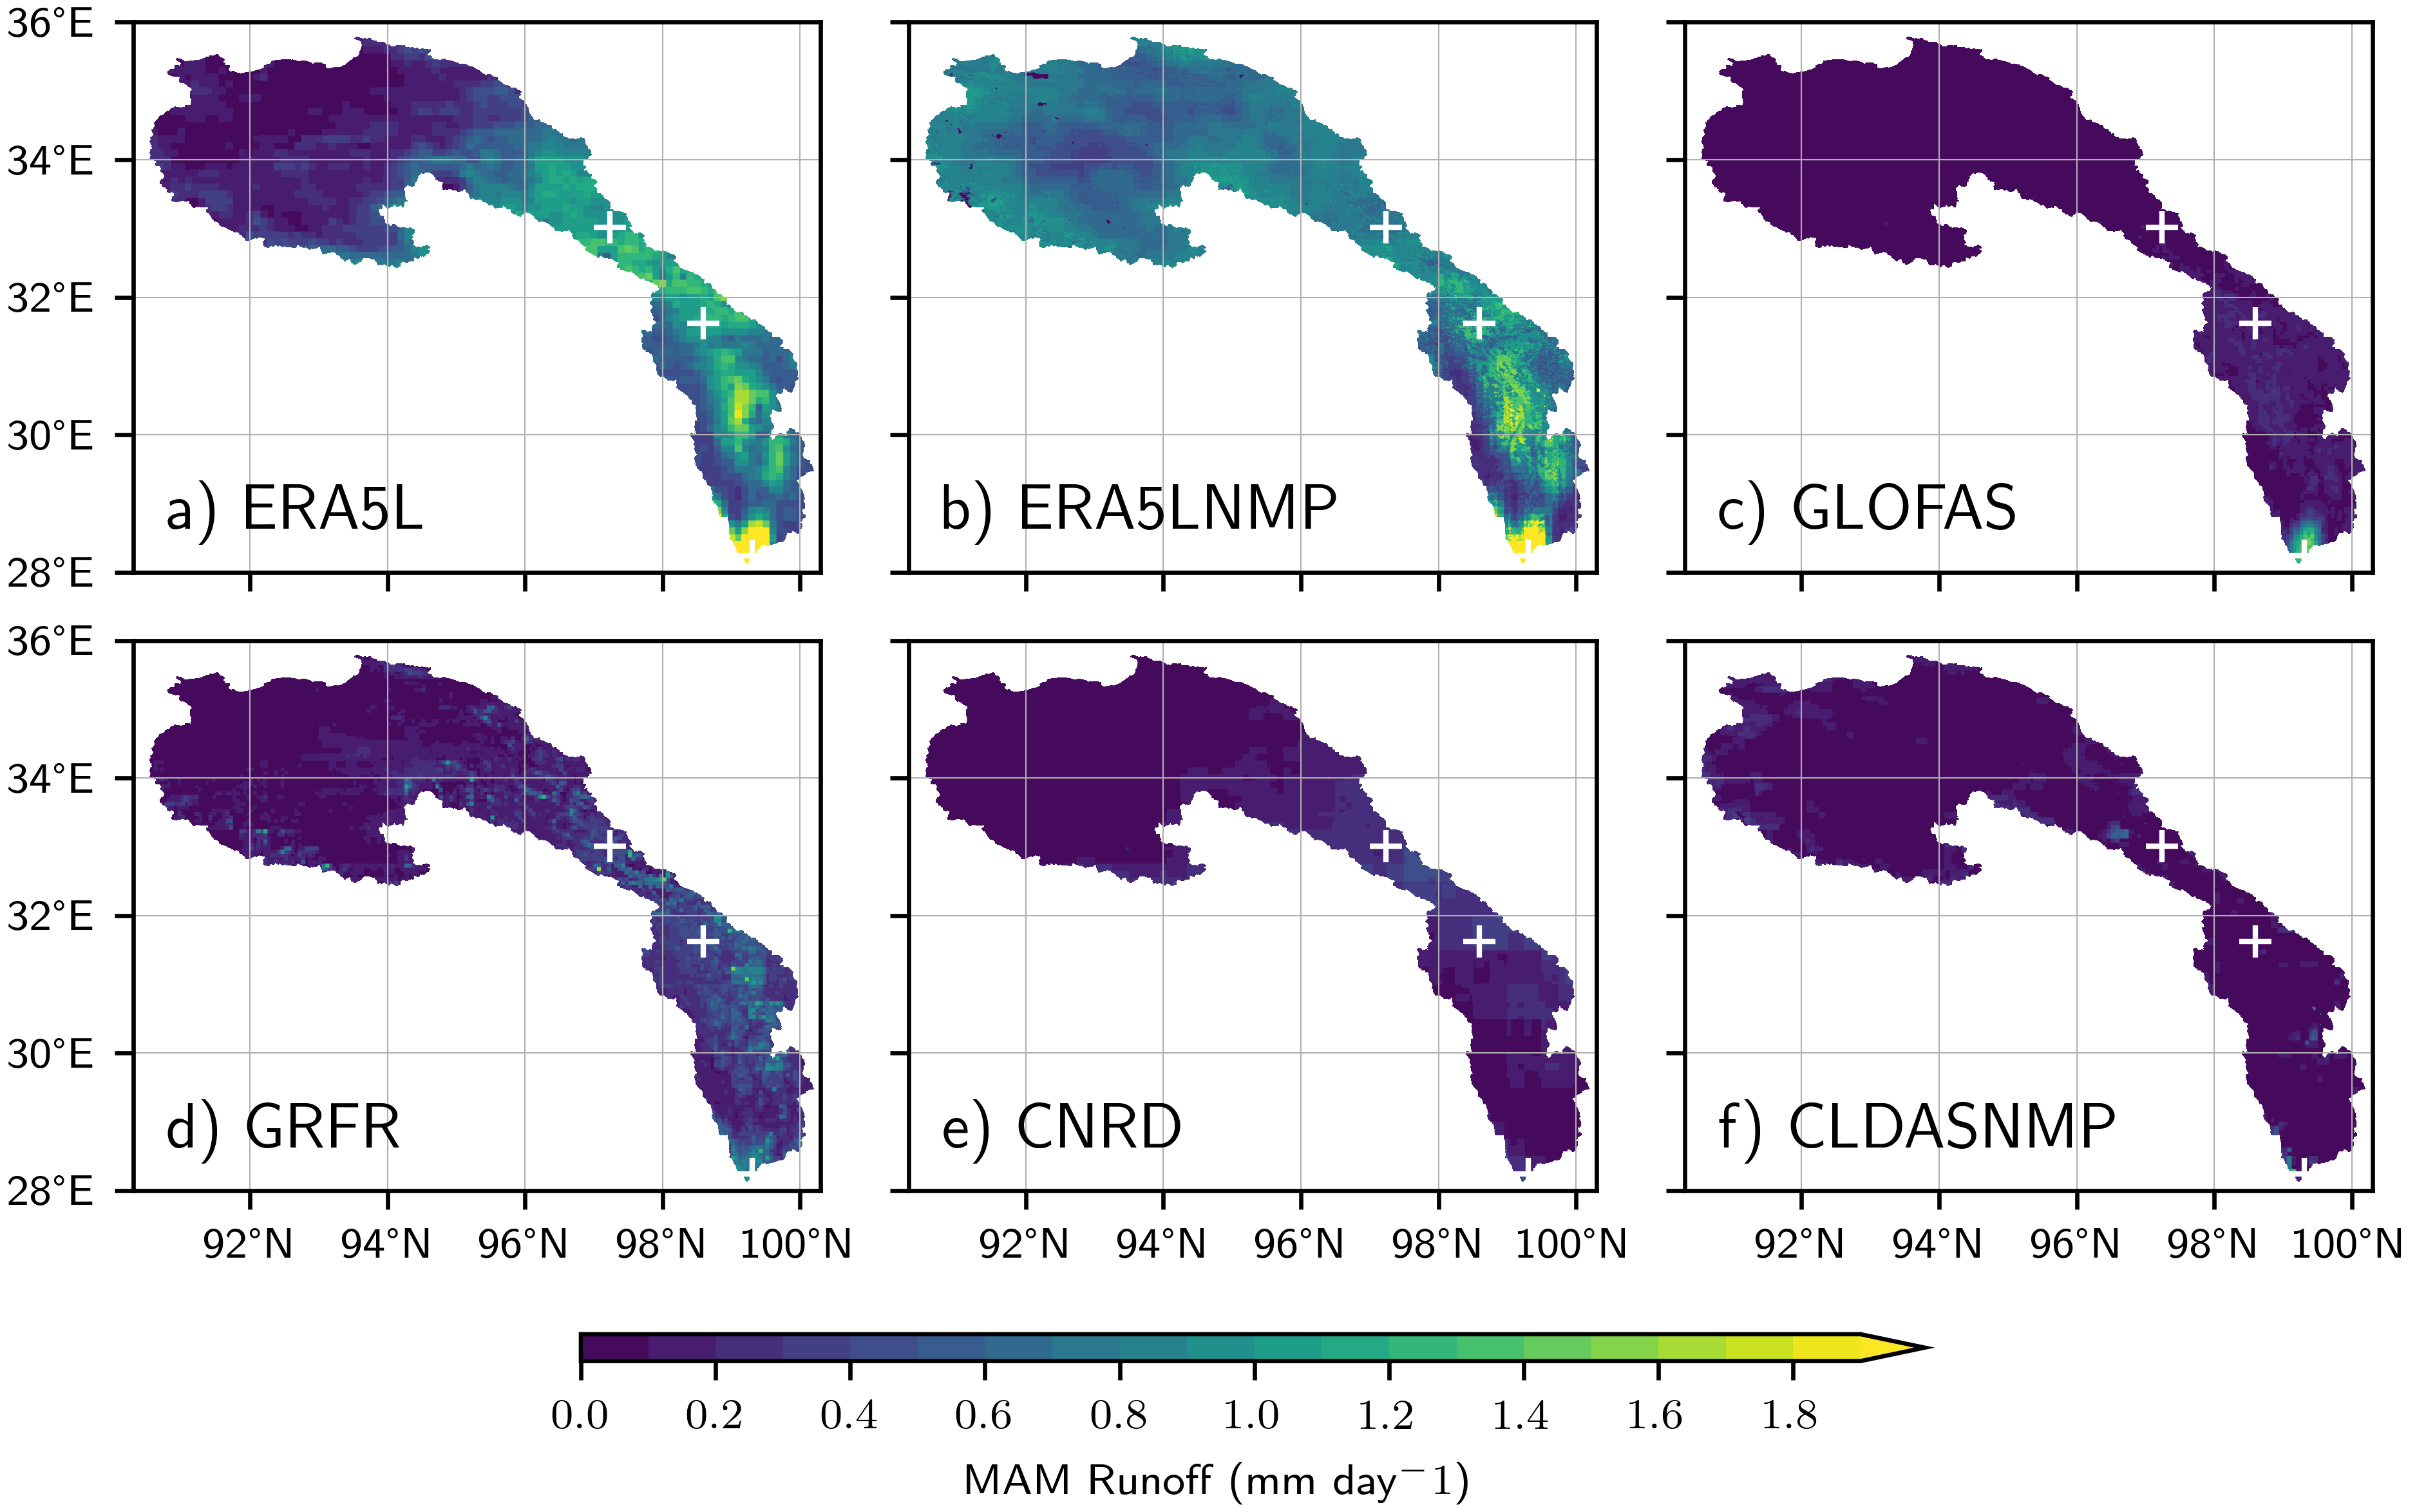

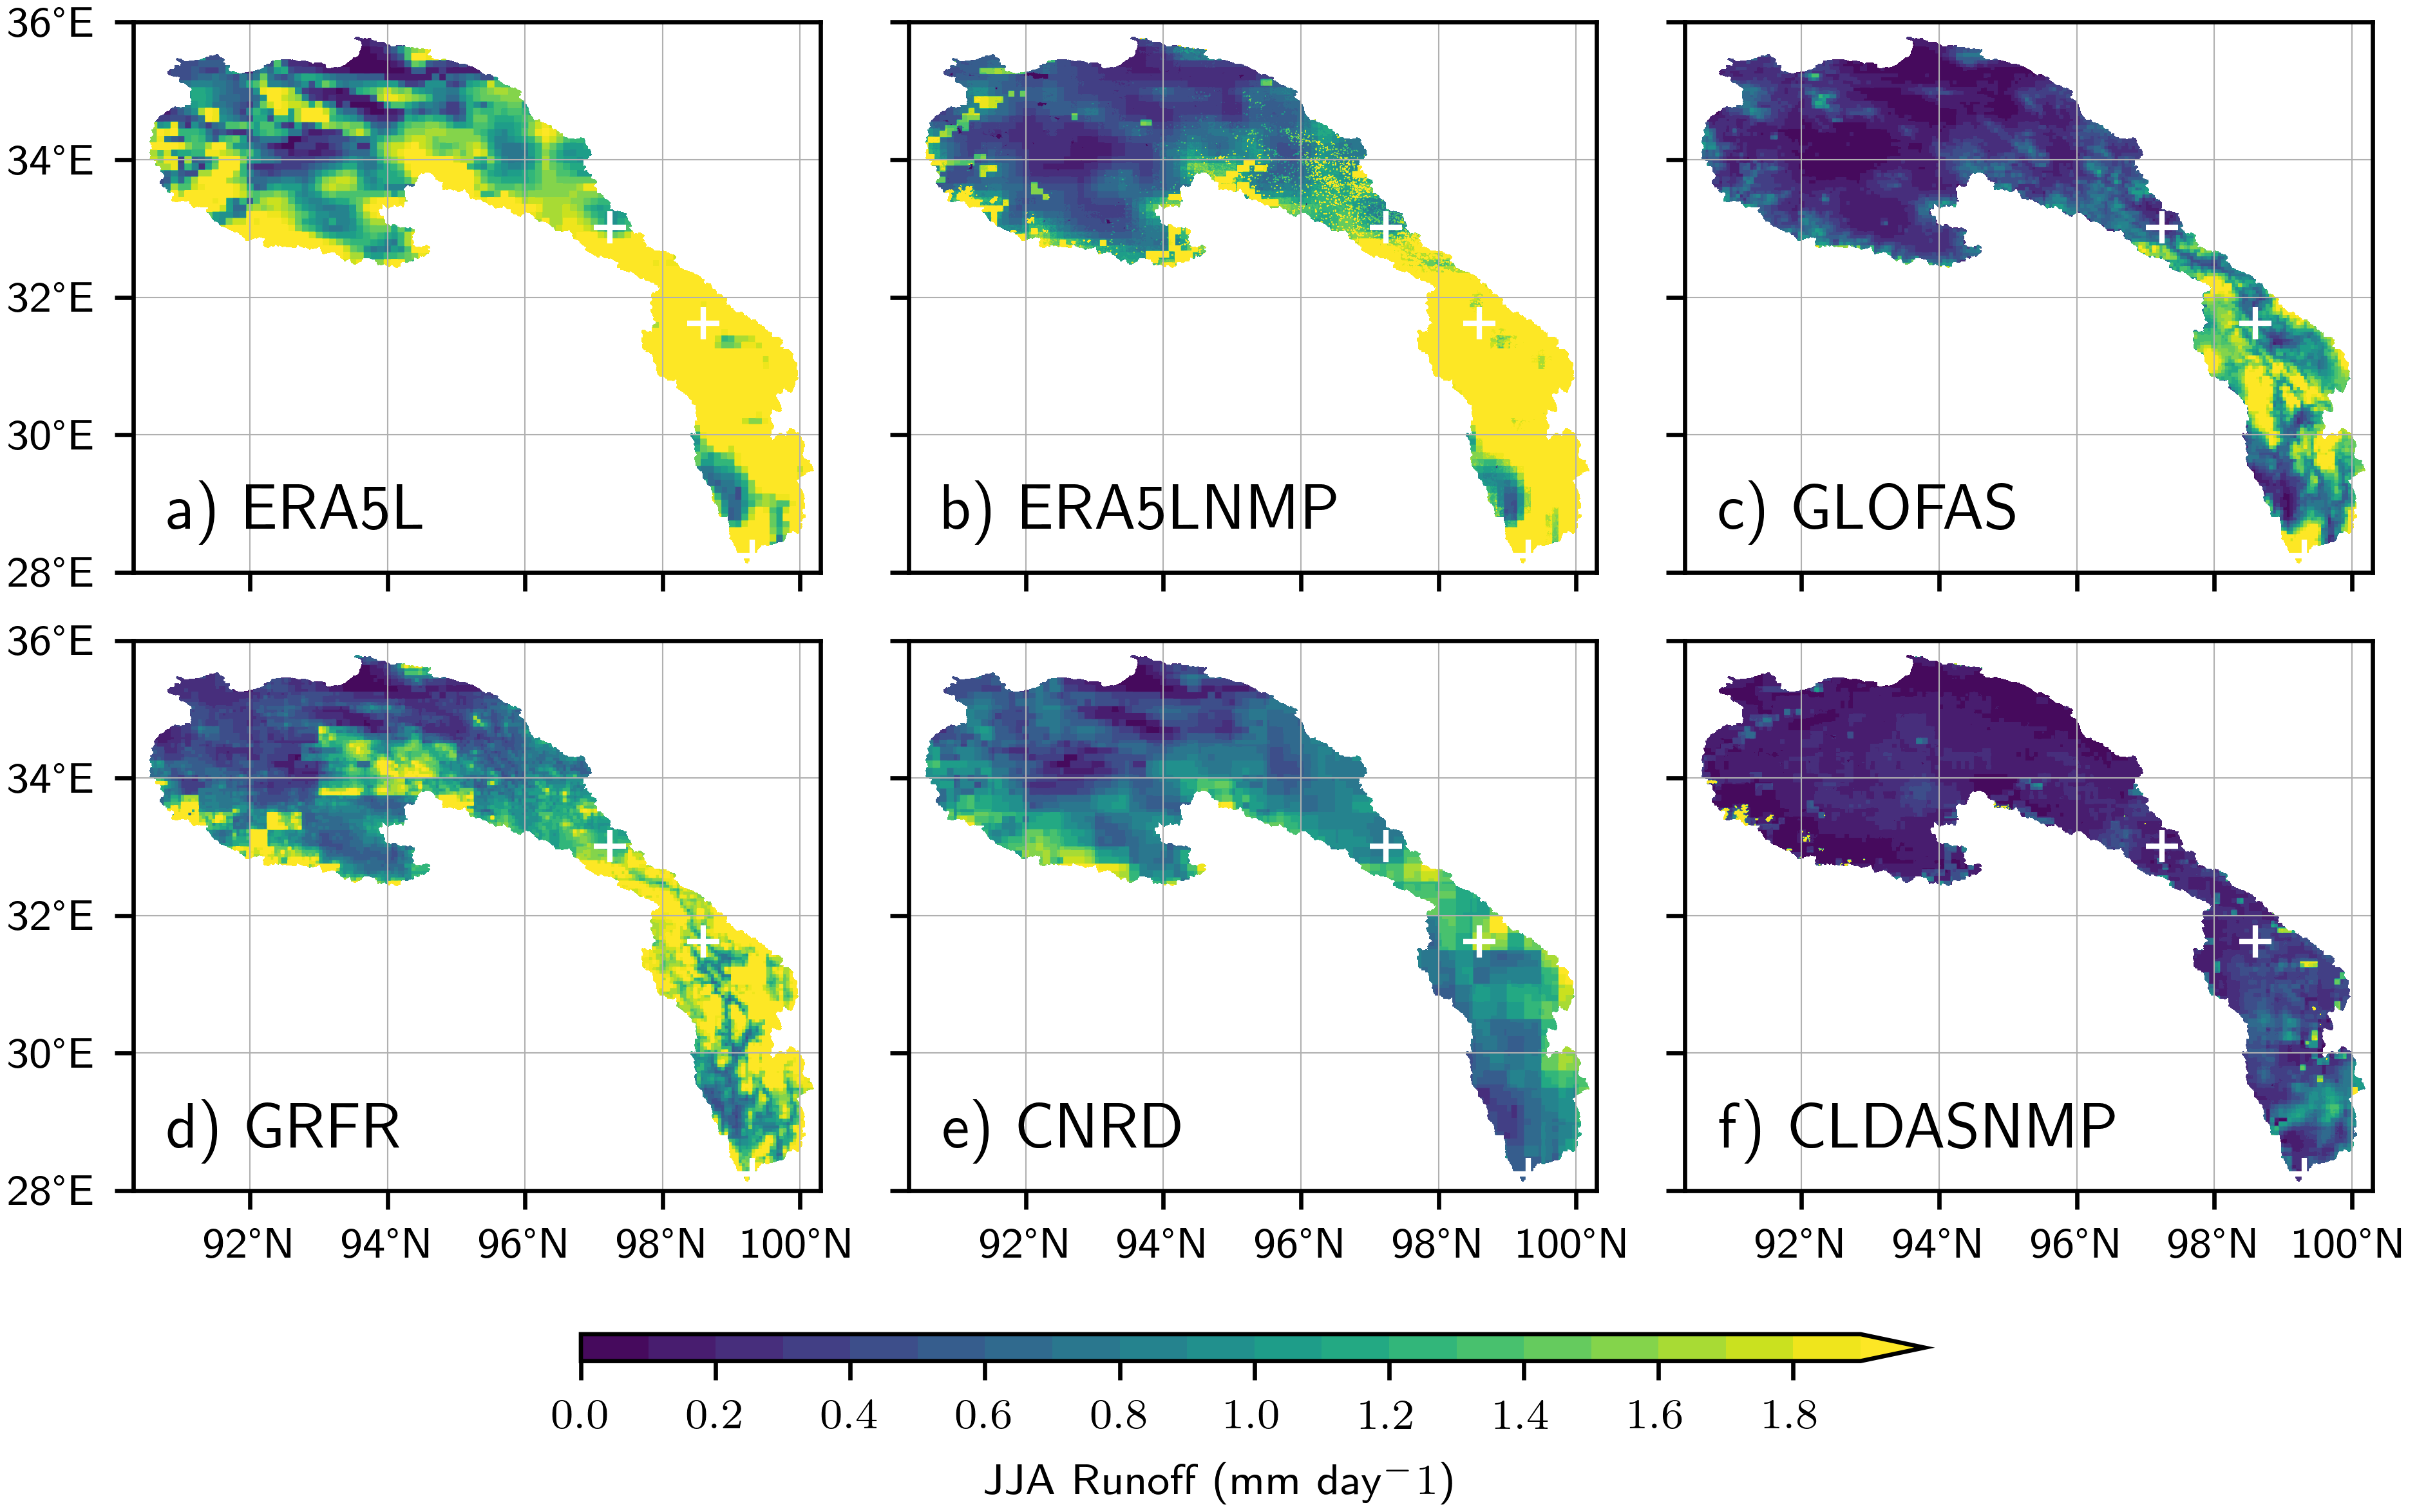

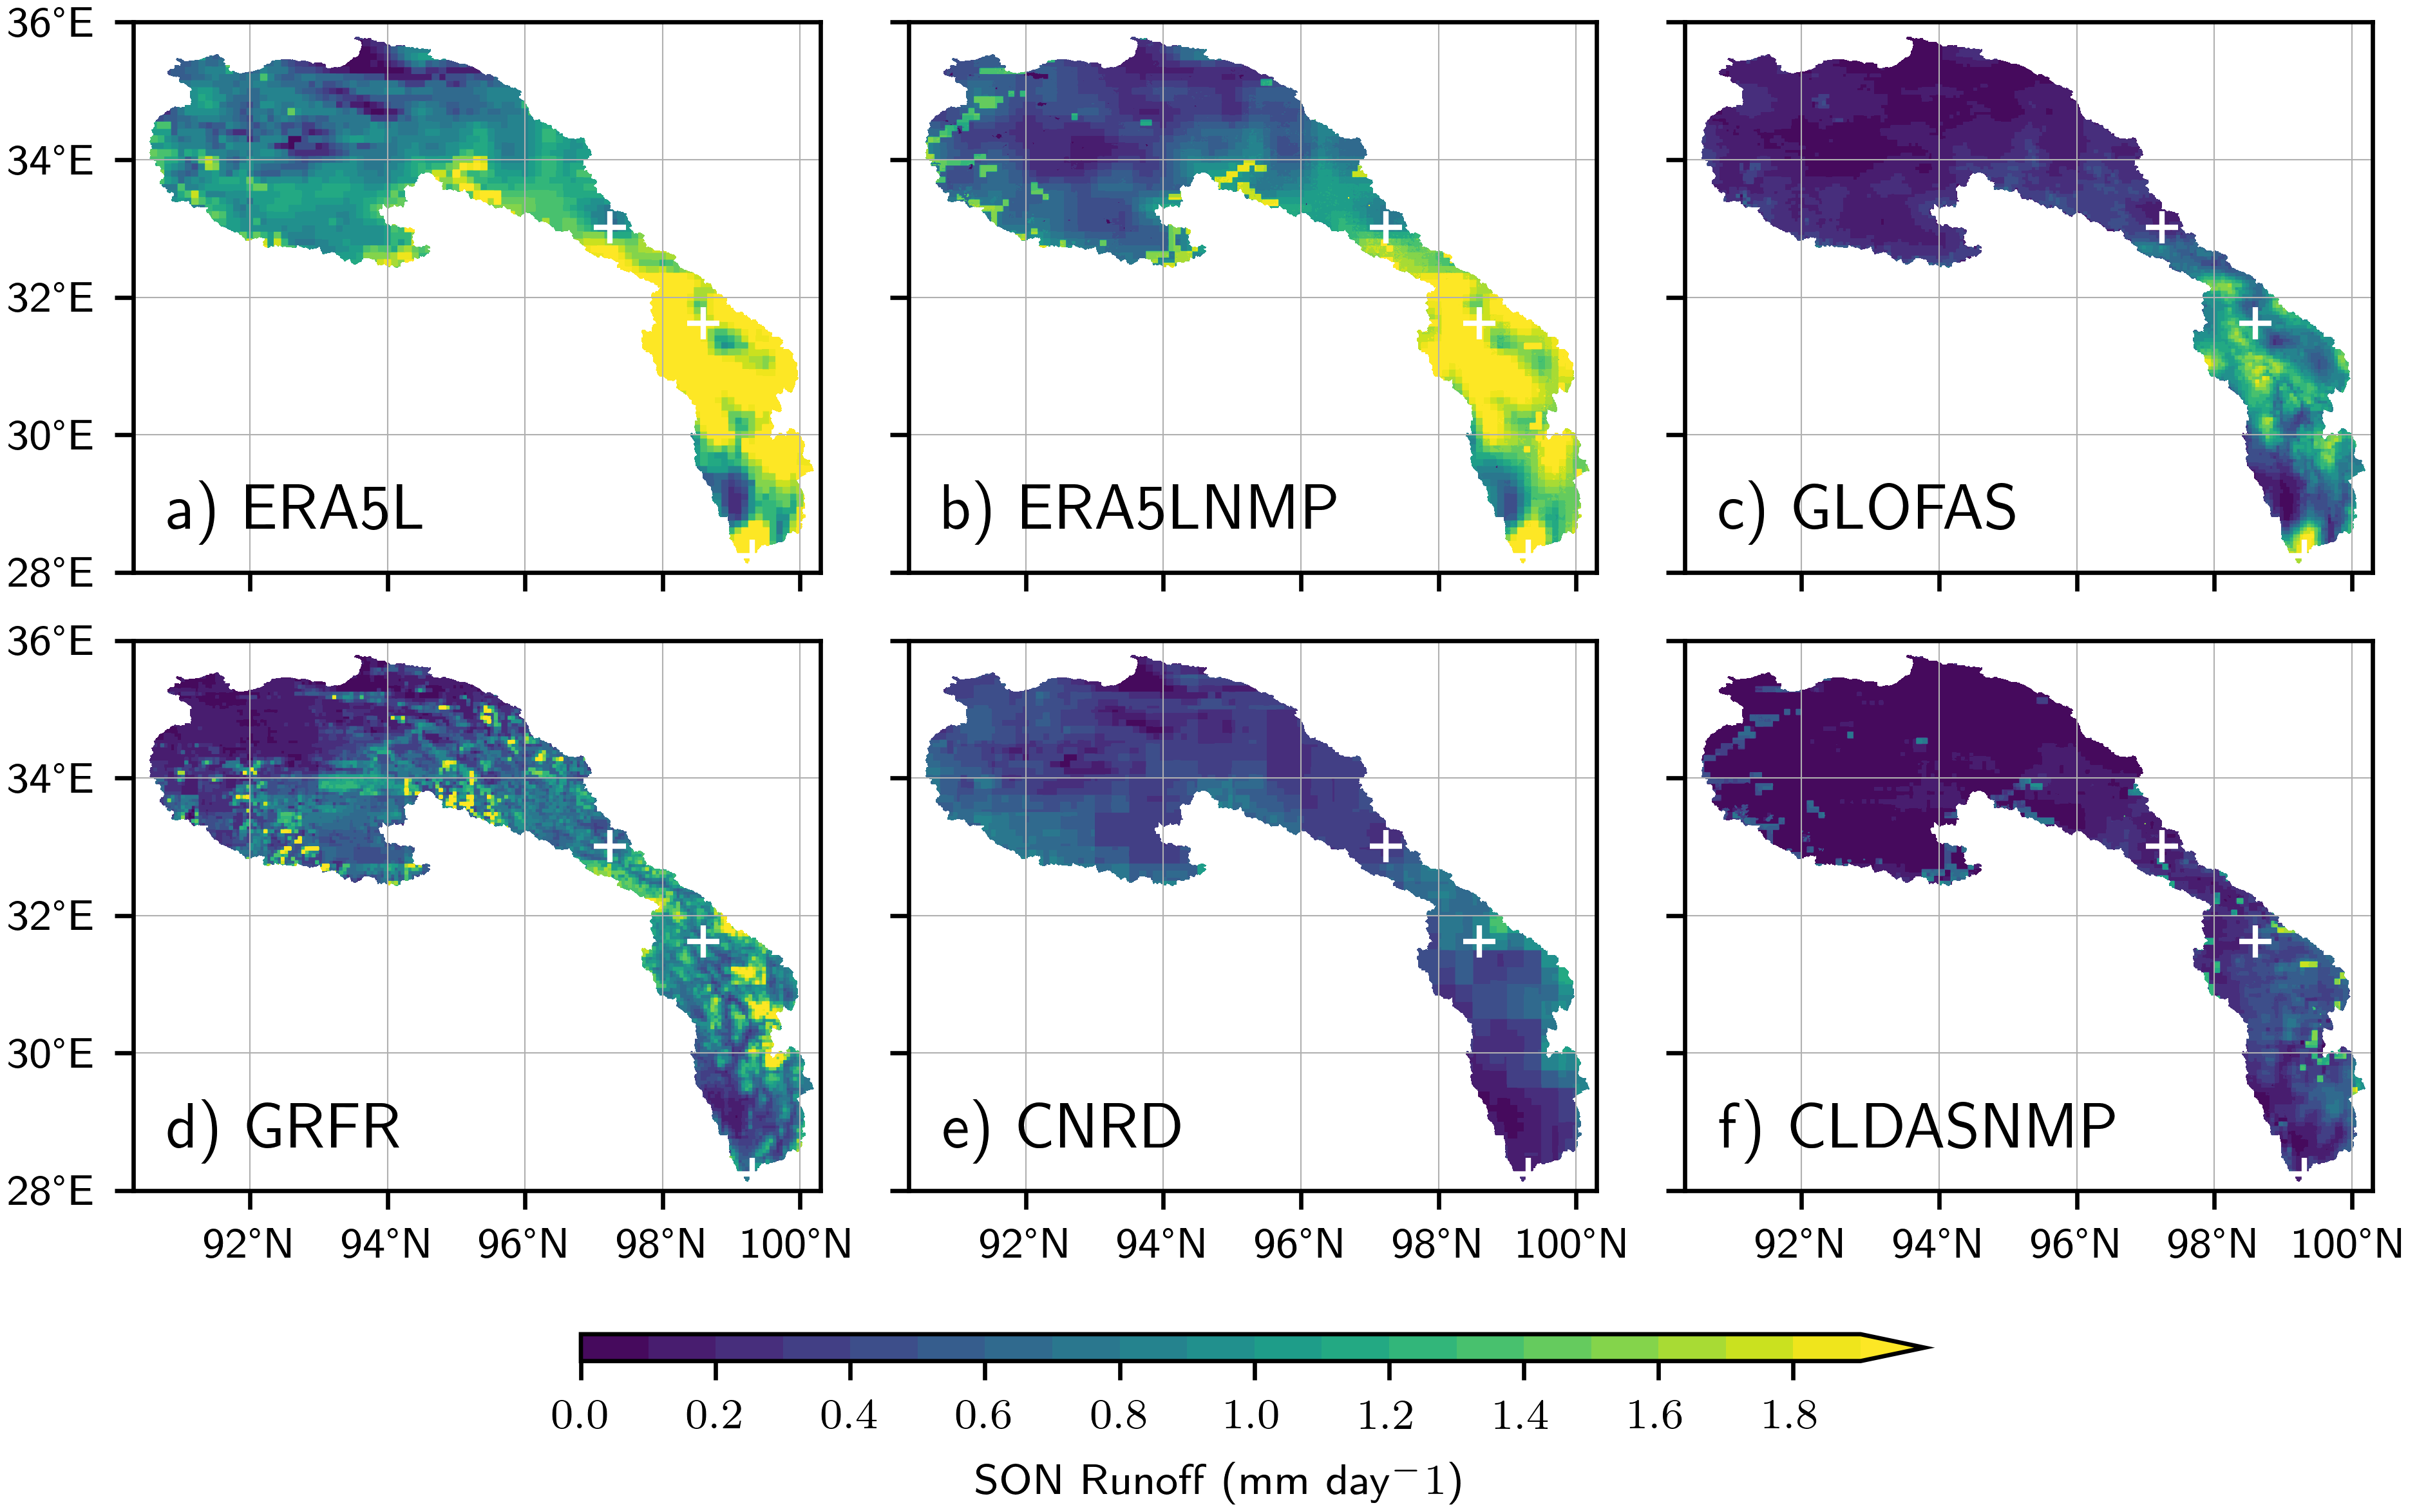

In [ ]:
levels = np.arange(0, 2.0, 0.1)

for season in ["DJF", "MAM", "JJA", "SON"]:
    fig = plt.figure(figsize=(16 / 2.54, 10 / 2.54), dpi=FIGDPI, layout="constrained")
    axs = fig.subplots(2, 3, sharex=True, sharey=True, squeeze=False)

    for i, dsn in enumerate(datanames):
        ax = axs.flat[i]
        cf = ax.contourf(
            runoff_seamean["lon"],
            runoff_seamean["lat"],
            (runoff_seamean[dsn].sel(season=season)) * (3600 * 24),
            levels=levels,
            extend="max",
        )
        ax.text(
            0.05,
            0.05,
            f"{string.ascii_lowercase[i]}) {dsn.upper()}",
            transform=ax.transAxes,
            ha="left",
            va="bottom",
            fontsize=12,
        )
        ax.set_xlabel("")
        ax.set_ylabel("")
        ax.set_aspect("equal")
        ax.grid(True)

        for sid in selected_stations:
            lat_, lon_ = station[sid]
            ax.plot(lon_, lat_, "+", color="white", markersize=6)

    axs[0, 0].set_yticks([28, 30, 32, 34, 36])
    axs[0, 0].set_yticklabels(["28°E", "30°E", "32°E", "34°E", "36°E"])
    axs[0, 0].set_ylim([28.0, 36])
    axs[0, 0].set_xticks([92, 94, 96, 98, 100])
    axs[0, 0].set_xticklabels(["92°N", "94°N", "96°N", "98°N", "100°N"])
    axs[0, 0].set_xlim([90.3, 100.3])

    cb = fig.colorbar(
        cf, ax=axs, orientation="horizontal", pad=0.05, aspect=50, shrink=0.6
    )
    cb.set_label(f"{season} Runoff (mm day$^{-1}$)")

    fig.savefig(
        FIGROOT.joinpath(f"runoff_mean_all_{season.lower()}").with_suffix(FIGSUFFIX),
        bbox_inches="tight",
    )